# Using xhistogram to convert ocean model output from depth to density coordinates

This notebook is adapted from one by Julius Busecke, https://github.com/jbusecke/cmip6-hackathon-demos/tree/master/notebooks

It is set up for beginners so that you can run without knowing very much python at all. If you are at a higher level, I suggest using Julius's notebook directly. 


In [1]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import gcsfs
from xhistogram.xarray import histogram

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

At this point you CAN create a cluster using the dask jupyterlab extension

This code will work for most models even if you don't do this.


1. First, click the "dask" symbol on the left (it looks a bit like a leaf)
2. Press "+new" to add a cluster
3. Press "scale" and give a number of workers (I suggest 4 or less)
4. Then click the "<>" symbol to inject the cluster as a cell
5. You have to run the cell for the cluster to work


In [2]:
#This code defines a function that lets us read the data later
def read_data(uri):
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [3]:
#This code defines a function that lets us rebin the data later
def vertical_rebin(data, bin_data, bins, dz, vert_dim="st_ocean"):
    nanmask = np.isnan(data)
    # Should we also check the bin data for nans?
    full_sum = histogram(
        bin_data.where(~nanmask),
        bins=[bins],
        weights=(data * dz).where(~nanmask),
        dim=[vert_dim],
    )
    return full_sum

def vertical_rebin_wrapper(
    ds,
    bin_data_name,
    bins,
    dz_name="dz",
    vert_dim="st_ocean",
    return_average=True,
    debug=False,
):
    """A wrapper for the core functionality in `vertical_rebin`.
    Accepts datasets and calculates the average over the new depth coordinates.
    """
    ds = ds.copy()
    ds_rebinned = xr.Dataset()
    
    ones = xr.ones_like(ds[dz_name])
    
    dz_rebinned = vertical_rebin(
        ones,
        ds[bin_data_name],
        bins,
        ds[dz_name],
        vert_dim=vert_dim,
    )
    for var in ds.data_vars:
        ds_rebinned[var] = vertical_rebin(
            ds[var], ds[bin_data_name], bins, ds[dz_name], vert_dim=vert_dim
        )
    if return_average:
        ds_rebinned = (
            ds_rebinned / dz_rebinned
        )  # this might cause a lot of overhead...i can try to deactivate if the save fails.

    ds_rebinned[dz_name] = dz_rebinned

    return ds_rebinned

The next cell reads the data. I suggest using Naomi Henderson's binder catalogue to identify what variables you want to put here. https://binder.pangeo.io/v2/gh/naomi-henderson/Pangeo-CMIP6-catalog-viewer.git/master?filepath=ViewCatalog.ipynb 

Click on the link and then ">Kernel >Restart & Run All" and then start exploring.

Because the next cell reads the data, it is the place where you are most likely to see errors. If you are getting errors, perhaps the data doesn't exist (check again in the catalogue). Temp, salinity and your data variable must exit on the same time points for this code to work. 

In [4]:
#Here is where you pick what variable you want to look at.
table_id='Omon'
variable_id='no3'

#Now pick what model you want to look at
source_id='CNRM-ESM2-1'
experiment_id='historical'

#first we load the catalogue
import pandas as pd
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')

#Then we load the variable you want
df_var = df[(df.table_id == table_id) & (df.variable_id == variable_id)]
uri = df_var[(df_var.source_id == source_id) &
                         (df_var.experiment_id == experiment_id)].zstore.values[0]
ds_var = read_data(uri)

#Now we also need to load temperature and salinity, so that we can find density
df_theta = df[(df.table_id == table_id) & (df.variable_id == 'thetao')]
uri = df_theta[(df_theta.source_id == source_id) &
                         (df_theta.experiment_id == experiment_id)].zstore.values[0]
ds_theta = read_data(uri)

df_salt = df[(df.table_id == table_id) & (df.variable_id == 'so')]
uri = df_salt[(df_salt.source_id == source_id) &
                         (df_salt.experiment_id == experiment_id)].zstore.values[0]
ds_salt = read_data(uri)

In [5]:
#Here we calculate the approximate potential density 
#(note: Not all CMIP6 models use TEOS-10, so this potential density is only approximate)
import gsw
dens=xr.apply_ufunc(gsw.density.sigma0,ds_salt['so'], ds_theta['thetao'],dask='parallelized', output_dtypes=[float, ]
                   ).rename('dens').to_dataset()

In [6]:
#Here we merge the data. You could have problems if you choose a variable that's not on T,S gridpoints
ds = xr.merge([dens, ds_var])


Now I need you to help me: not all the datasets have the same vertical or horizontal coordinates. So run the cell below,  find the names of these coordinates and give them in the next cell. 

In [7]:
ds

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, lev: 75, nvertex: 4, time: 1980, x: 362, y: 294)
Coordinates:
    lat          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lon          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    bounds_lat   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lon   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lev_bounds   (lev, axis_nbounds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    dens         (time, lev, y, x) float64 dask.array<chunksize=(12, 75, 294, 362), meta=np.ndarray>
    no

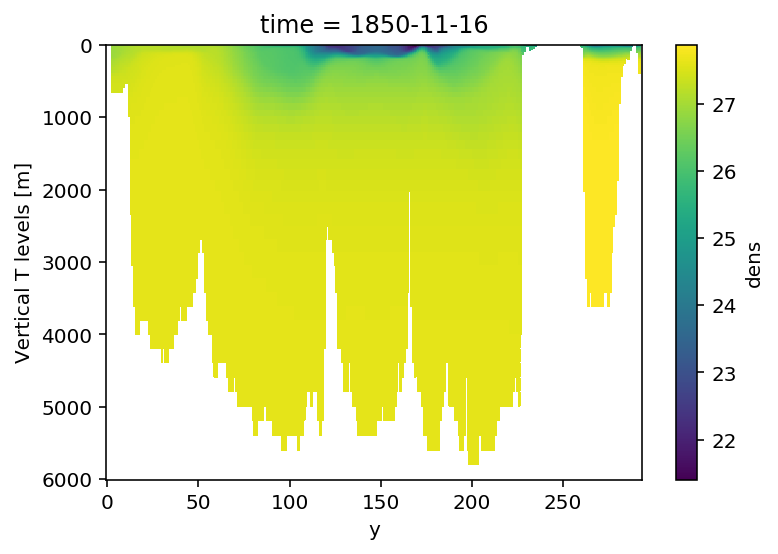

In [8]:
#Define vertical coord
vert_coord='lev'

#Define x-coord and y-coord
x_coord='x'
y_coord='y'

ds=ds.rename_dims({x_coord:'x'})
ds=ds.rename_dims({y_coord:'y'})

#now I'm going to plot a cross section of density
#so that you can figure out what potential density surfaces you want to pick

roi = dict(x=125, time=10)
ds.dens.isel(**roi).plot(yincrease=False)

You may need to adjust the potential density bins you want in the cell below

In [11]:
#define bins (in units of potential density)
bins = np.arange(20, 30, 0.2)

In [12]:
# Actually rebin the data
ds_rebinned = vertical_rebin_wrapper(ds,
                                     'dens',
                                     bins,
                                     dz_name=vert_coord,
                                     vert_dim=vert_coord)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


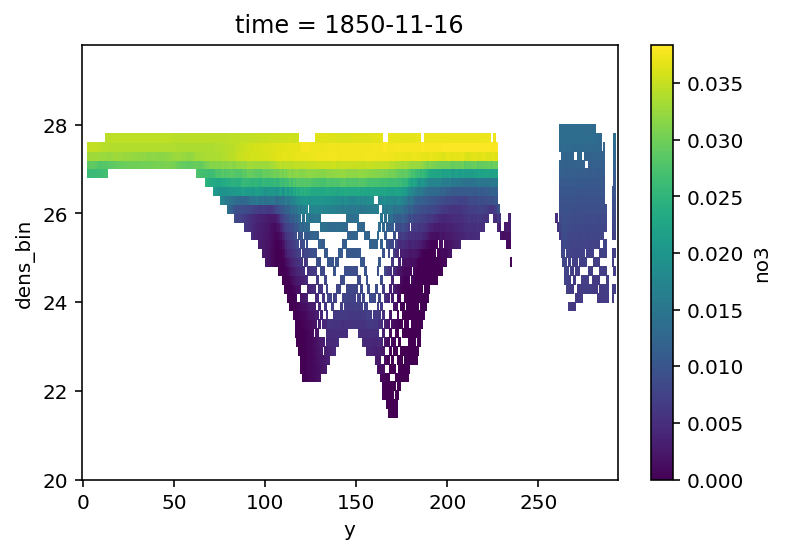

In [13]:
# plot a slice in density coordinates
roi = dict(x=125, time=10)

ds_rebinned[variable_id].isel(**roi).plot(x='y')


In [14]:
#You can use this statement to figure out the index of the density surface you want to plot\
ds_rebinned['dens_bin'][30]

<xarray.DataArray 'dens_bin' ()>
array(26.1)
Coordinates:
    dens_bin  float64 26.1

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


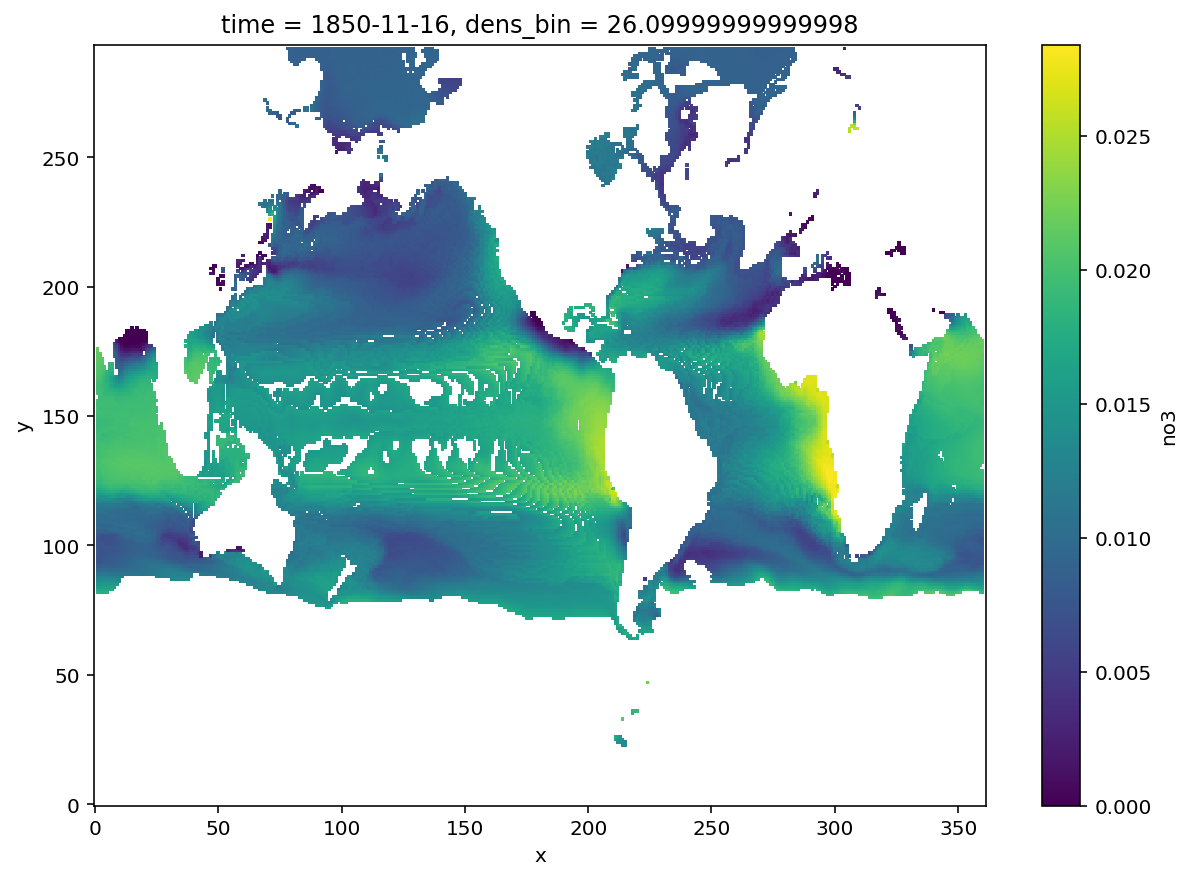

In [15]:
# plot a horizontal density surface
roi = dict(dens_bin=30, time=10)
plt.figure(figsize=(10,7))
ds_rebinned[variable_id].isel(**roi).plot(x='x',y='y',cmap='viridis')